## The Sugarscape.

The "Sugarscape" is a landscape (in the form of a lattice) where **sugar grows in each cell**.

The sugar provides energy and wealth.

**Agents explore the landscape** and, while doing it, harvest the sugar. 

- Each round, each agent move once. They move sequentially. Each round, the order in which the agent move is random.

- Two agents can't share the same cell: if an agent can't move on a free cell within its range, it remains in the cell it occupies.

- Each agent pays a metabilic cost to remain alive and move on the sugarscape. When their energy (that corresponds to their sugar level) falls below zero then they die of starvation.

At the end of each round, the **landscape regrowth the sugar** according to the growth rule $G_{\rm g}$.

In our implementation we also combine agents genetics randomly after a certain amount of time. In order to analyze which traits are better suited for survival. 

### Features of the Sugarscape.

We start from the classical implementation: 

- squared lattice $N \times N$

- sugar full capacity of each cell: from 0 to 4

- landscape shaped like two sugar-hills

- rule $G_{\infty}$: at the end of each round, the sugar regrowth instantly to the maximum capacity of each cell.


### Agents on the Sugarscape.

Agents on sugarsape have the following features:

- vision: $v$ (uniform distribution $\in \{1, 2, ..., 6 \}$)
- sugar: $s$ (uniform distribution $\in \{5, 6, ... 25 \}$)
- metabolism: $m$ (uniform distribution $\in \{1, 2, 3, 4 \}$)

The vision determines the motion range.

The sugar is a reservoir of energy.

The metabolism represents the enegy each agents demands per round to survive. 



In [2]:
import numpy as np
import pandas as pd
from random import sample

In [3]:
def move_agents(SuSca, agents, N):
    """
    Function to move the agents on the sugarscape using a pandas DataFrame.
    Implements one round where all agents move once, ensuring no two agents occupy the same cell.
    
    Parameters
    ==========
    SuSca : 2D numpy array representing the sugarscape (sugar levels at each position).
    agents : pandas DataFrame containing agent attributes and positions.
    N : Size of the sugarscape grid (NxN).
    max_vision : Maximum vision range for agents.

    Returns
    =======
    Updated sugarscape grid and agents DataFrame.
    """
    Nx, Ny = SuSca.shape
    SuSca = SuSca.copy()
    
    # Shuffle agent order to randomize movement
    agents = agents.sample(frac=1).reset_index(drop=True)
    
    # Create a set of occupied cells (x, y)
    occupied_cells = set(zip(agents["x"], agents["y"]))
    
    for i, agent in agents.iterrows():
        # Get agent's properties
        x, y = int(agent["x"]), int(agent["y"])   # position of the agent 
        vision = int(agent["vision"])  # Scale vision to an integer
        sugar = agent["sugar"]
        metabolism = agent["metabolism"]
        
        # Determine visible cells within vision range
        visible_positions = []
        for dx in range(-vision, vision + 1):
            for dy in range(-vision, vision + 1):
                if abs(dx) + abs(dy) <= vision:  # Manhattan distance
                    new_x = int((x + dx) % Nx)
                    new_y = int((y + dy) % Ny)
                    if (new_x, new_y) not in occupied_cells:  # Skip occupied cells
                        visible_positions.append((new_x, new_y))
        
        if not visible_positions:
            # No valid moves; this agent is stuck
            continue
        
        # Find the cell with the highest sugar within vision
        # Here it might be possible to add a new lambda key, representing radiation for example. 
        best_cell = max(
            visible_positions,
            key=lambda pos: SuSca[pos[0], pos[1]]
        )
        
        # Move agent to the best cell
        new_x, new_y = best_cell
        agents.at[i, "x"] = new_x
        agents.at[i, "y"] = new_y
        
        # Update occupied cells safely
        if (x, y) in occupied_cells:
            occupied_cells.remove((x, y))  # Free the old cell
        occupied_cells.add((new_x, new_y))  # Mark the new cell as occupied
        
        
        # Collect sugar from the new cell
        agents.at[i, "sugar"] += SuSca[new_x, new_y] #*10
        SuSca[new_x, new_y] = 0  # Deplete the cell's sugar
        
        # Pay the metabolic cost
        agents.at[i, "sugar"] -= metabolism


    # Remove agents with sugar <= 0 (they "die"), then reset the index of the DataFrame
    agents = agents[agents["sugar"] > 0].reset_index(drop=True)
    
    return SuSca, agents


Initialize the sugarscape in the "classical" way.

In [4]:


### Function to initialize the sugarscape with integer values ###
# def initialize_sugarscape(N):
#     """
#     Function to generate the "classical" sugarscape.
    
#     Parameters
#     ==========
#     N : Side of the sugarscape lattice.
#     """
    
#     # Initialize SuSca with integer values
#     SuSca = np.zeros([N, N], dtype=int)  # Ensure the matrix is integer
    
#     # Create grid of coordinates
#     X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
#     # Define the center locations for the sugar sources
#     x_centers = np.array([N / 4, 3 * N / 4])
#     y_centers = np.array([N / 4, 3 * N / 4])

#     # Define the radius levels and sugar levels
#     r_levels = np.array([4, 3, 2, 1]) / 4 * (np.sqrt(2) / 4) * N
#     s_levels = np.array([1, 2, 3, 4])
    
#     # Loop through the centers and assign sugar values
#     for k in range(np.size(x_centers)):
#         # Calculate distance from the center to each point on the grid
#         d = np.sqrt((X - x_centers[k]) ** 2 + (Y - y_centers[k]) ** 2)
        
#         # Loop through the sugar levels
#         for i in range(np.size(s_levels)):
#             # Determine the region within the radius and assign sugar levels
#             region = np.where(d <= r_levels[i])
#             SuSca[region[0], region[1]] = s_levels[i]
    
#     return SuSca

#print(initialize_sugarscape(10))




In [5]:
import numpy as np

# Example 2D matrix
matrix = np.array([
    [0.1, 0.2, 0.8],
    [0.4, 0.10, 0.1],
    [0.5, 0.7, 0.3]
])

# Get the maximum value in the matrix
max_value = np.max(matrix)
print(matrix*10)

# Get the index of the maximum value
max_index = np.unravel_index(np.argmax(matrix), matrix.shape)

print("Maximum value:", max_value)
print("Index of maximum value:", max_index)


[[1. 2. 8.]
 [4. 1. 1.]
 [5. 7. 3.]]
Maximum value: 0.8
Index of maximum value: (0, 2)


In [6]:
def initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar):
    """
    Function to generate a sugarscape with Gaussian-distributed sugar levels.
    
    Parameters
    ==========
    N : int
        Size of the sugarscape lattice (NxN).
    spot_positions : array-like
        List of (x, y) positions where sugar "hotspots" are centered.
    spot_widths : array-like
        List of standard deviations (sigma) for the Gaussian spread of each hotspot.
    max_sugar : float
        Maximum sugar value to normalize the distribution.
        
    Returns
    =======
    SuSca : ndarray
        2D array of sugar levels.
    """
    # Initialize the sugarscape grid
    SuSca = np.zeros((N, N), dtype=float)

    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # defining threshold for low sugar cell
    threshold = 0.1 * max_sugar
    


    # Loop over all sugar hotspots
    for i, (x_center, y_center) in enumerate(spot_positions):
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        
        # Apply periodic boundary conditions
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N

        # Compute the radial distance
        r = np.sqrt(dx**2 + dy**2)

        # Add Gaussian sugar levels to the grid
        SuSca += gauss(r, spot_widths[i])

    # Normalize sugar levels to the max_sugar value
    nSuSca = SuSca*10 #max_sugar #/ np.max(SuSca)

    return nSuSca



In [7]:
def regenerate_hotspots(SuSca, N, num_hotspots, max_sugar, peak_value=5.0, sigma=3.0):
    """
    Function to regrow sugar in the Sugarscape using gradient-based hotspots.

    Parameters
    ==========
    SuSca : ndarray
        Current sugar levels in the Sugarscape.
    N : int
        Size of the Sugarscape (NxN).
    num_hotspots : int
        Number of new sugar hotspots to create.
    max_sugar : float
        Maximum possible sugar value per cell.
    peak_value : float
        Maximum sugar value at the hotspot center.
    sigma : float
        Standard deviation controlling the spread of the sugar gradient.

    Returns
    =======
    SuSca : ndarray
        Updated sugar levels with new hotspots.
    """
    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # Add new sugar gradients to the Sugarscape
    for _ in range(num_hotspots):
        # Randomly select a new hotspot center
        x_center, y_center = np.random.randint(0, N, size=2)

        # Calculate distances with periodic boundary conditions
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N
        r = np.sqrt(dx**2 + dy**2)

        # Add a new sugar gradient to the Sugarscape
        new_sugar = peak_value * gauss(r, sigma)
        SuSca += new_sugar

    # Clip sugar levels to ensure they don't exceed max_sugar
    SuSca = np.clip(SuSca, 0, max_sugar)
    
    return SuSca


Defining GA-Logic. All pretty self explanatory. 


In [8]:
def calculate_fitness(agent): 
    # A simple fitness function
    # What do we want to have as fitness? 
    fitness = agent['sugar'] #* agent['metabolism'] * agent['vision']
    return fitness

def select_parents(agents, num_parents):
    parents = []
    for _ in range(num_parents):
        selected = agents.sample(3)  # Select 3 random agents for the tournament
        parent = selected.loc[selected['fitness'].idxmax()]  # Select the best one
        parents.append(parent)
    return pd.DataFrame(parents)

def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, 3)  # Randomly choose a point (since there are 3 traits)
    
    child1 = parent1.copy()
    child2 = parent2.copy()

    # Swap the genes after the crossover point
    if crossover_point == 0:
        child1['sugar'], child2['sugar'] = parent2['sugar'], parent1['sugar']
    elif crossover_point == 1:
        child1['metabolism'], child2['metabolism'] = parent2['metabolism'], parent1['metabolism']
    elif crossover_point == 2:
        child1['vision'], child2['vision'] = parent2['vision'], parent1['vision']
    
    return child1, child2


def mutate(agent, mutation_rate=0.01):
    if np.random.rand() < mutation_rate:
        # Randomly choose one attribute to mutate
        attribute_to_mutate = np.random.choice(['metabolism', 'vision'])
        agent[attribute_to_mutate] = np.random.randint(1, 5)
    return agent


def replace_population(agents, new_agents):
    return pd.concat([agents, new_agents]).reset_index(drop=True)

Function to convert a 2 dimensional numpy array into a RGB image.

In [9]:
def convert2RBG(game_outcome, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

Initialize the sugarscape


10.0041751086085


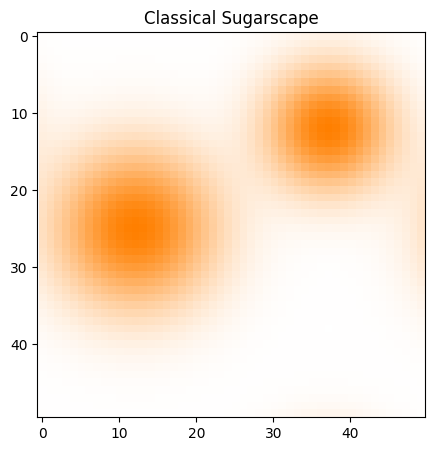

In [10]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.
spot_positions = [(N //4, N // 2), (3 * N // 4, 1 * N // 4), ]  # Center of the sugar spots.
spot_widths = [N / 7, N / 9]  # Width of the sugar spots.
max_sugar = 10  # Maximum sugar level.


SuSca = initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar)

print(np.max(SuSca))
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


In [11]:
def convert2RGB(game_outcome, RGB0, RGB1):
    """
    Function to convert the 2-dimensional numpy array into an RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the sugar distribution.
    RGB0 : Components R, G, B of the chosen color shade for minimum sugar.
    RGB1 : Components R, G, B of the chosen color shade for maximum sugar.
    """
    # Get the dimensions of the game outcome
    [n_rows, n_cols] = game_outcome.shape
    
    # Initialize the RGB image
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Normalize the sugar levels to be between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    # Map the normalized sugar levels to RGB
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

In [12]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400 # Number of agents on the sugarscape.

x_positions = np.random.randint(0, N, A)  # Random X positions
y_positions = np.random.randint(0, N, A)  # Random Y positions

# Create the agents with random integers between 1 and 5
agents = pd.DataFrame({
    "sugar": np.random.randint(1, 6, A),        # Random integers between 1 and 5 for sugar
    "metabolism": np.random.randint(1, 6, A),   # Random integers between 1 and 5 for metabolism
    "vision": np.random.randint(1, 6, A),       # Random integers between 1 and 5 for vision
    "fitness": np.zeros(A),                     # Initialize fitness to 0
    "x": x_positions,                           # X-coordinate of agent
    "y": y_positions                            # Y-coordinate of agent
})


print(agents)


     sugar  metabolism  vision  fitness   x   y
0        5           2       3      0.0  35  47
1        5           2       1      0.0  39   1
2        3           4       1      0.0   8   0
3        1           3       5      0.0   9  28
4        4           5       2      0.0  33  39
..     ...         ...     ...      ...  ..  ..
395      4           2       1      0.0  34  11
396      5           2       3      0.0  41  30
397      5           1       2      0.0   2  17
398      3           3       1      0.0  15  21
399      4           4       3      0.0   3  23

[400 rows x 6 columns]


[<Color white>, <Color #f2efef>, <Color #e9dedc>, <Color #e3ccc6>, <Color #e0bcad>, <Color #e0ad91>, <Color #e3a271>, <Color #e99c4f>, <Color #f29d29>, <Color orange>]


C:\Users\sagal\AppData\Local\Temp\ipykernel_15364\2747661489.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.0143862574930065' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  agents.at[i, "sugar"] += SuSca[new_x, new_y] #*10


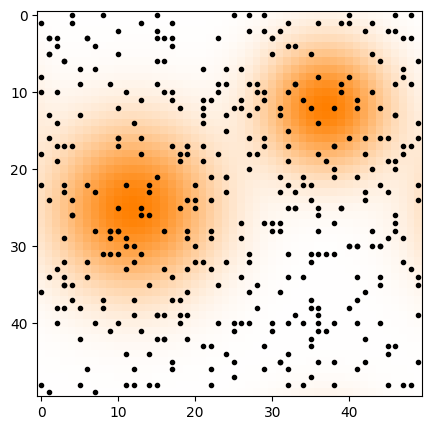

     sugar  metabolism  vision  fitness   x   y
0        5           2       3      5.0  35  47
1        5           2       1      5.0  39   1
2        3           4       1      3.0   8   0
3        1           3       5      1.0   9  28
4        4           5       2      4.0  33  39
..     ...         ...     ...      ...  ..  ..
395      4           2       1      4.0  34  11
396      5           2       3      5.0  41  30
397      5           1       2      5.0   2  17
398      3           3       1      3.0  15  21
399      4           4       3      4.0   3  23

[400 rows x 6 columns]


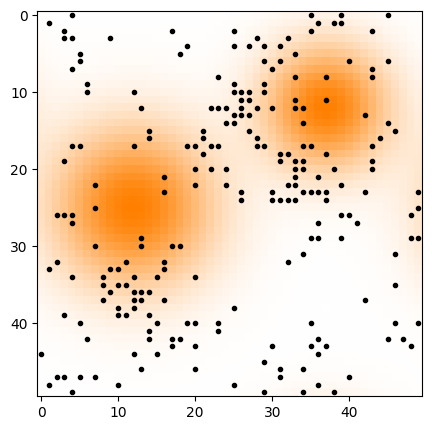

        sugar  metabolism  vision   fitness   x   y
0    2.014386           2       2  2.014386  46  35
1    2.454582           1       5  2.454582  13  30
2    1.011103           3       2  1.011103   4   3
3    3.057812           2       1  3.057812  38   1
4    0.772220           5       2  0.772220  16  37
..        ...         ...     ...       ...  ..  ..
225  1.716208           2       1  1.716208  28  17
226  1.434291           2       4  1.434291  31  19
227  3.413735           2       4  3.413735  28   3
228  3.915153           1       2  3.915153  28  12
229  2.915178           2       5  2.915178  25   9

[230 rows x 6 columns]


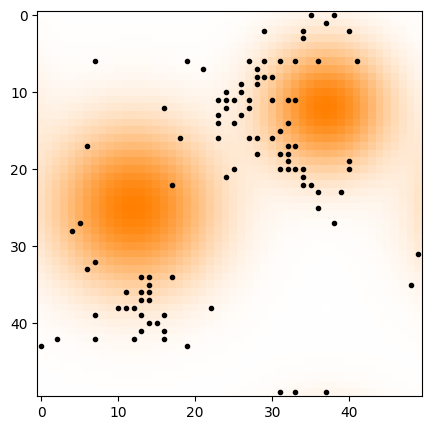

        sugar  metabolism  vision   fitness   x   y
0    0.782719           2       4  0.782719  27  12
1    2.264176           1       3  2.264176  22  38
2    1.044420           2       3  1.044420  49  31
3    4.109391           1       5  4.109391  16  39
4    2.811525           1       5  2.811525  25  11
..        ...         ...     ...       ...  ..  ..
98   1.080226           2       3  1.080226  40  20
99   1.131810           2       1  1.131810  37   1
100  2.275638           1       5  2.275638  28   8
101  1.056011           2       2  1.056011  16  41
102  1.868223           2       2  1.868223  31   6

[103 rows x 6 columns]


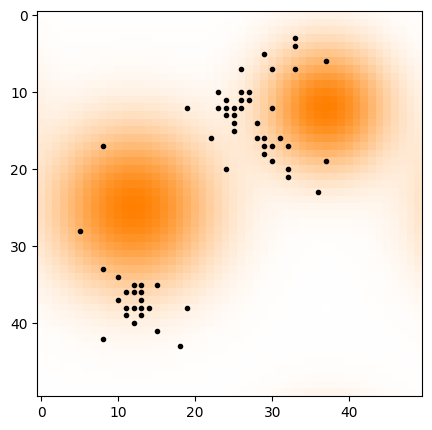

       sugar  metabolism  vision   fitness   x   y
0   2.931527           1       4  2.931527  25  12
1   1.241010           1       4  1.241010  37   6
2   1.630520           1       4  1.630520  25  13
3   2.154644           1       3  2.154644  36  23
4   3.332963           1       1  3.332963   8  42
..       ...         ...     ...       ...  ..  ..
56  1.258369           2       2  1.258369  12  40
57  0.978478           2       5  0.978478  23  10
58  4.421374           1       5  4.421374  11  36
59  2.080310           1       2  2.080310   8  17
60  0.343844           2       2  0.343844   8  33

[61 rows x 6 columns]


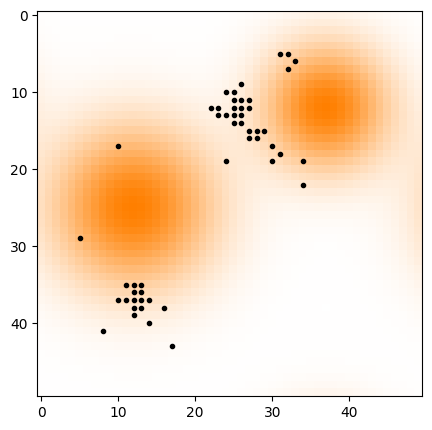

       sugar  metabolism  vision   fitness   x   y
0   0.813198           1       4  0.813198  31   5
1   2.964495           1       1  2.964495  24  19
2   0.287292           1       5  0.287292  26  14
3   0.799896           1       3  0.799896  12  37
4   0.196271           2       2  0.196271  12  39
5   1.208759           1       1  1.208759  17  43
6   0.869606           1       2  0.869606  26   9
7   0.905779           2       5  0.905779  11  37
8   3.682931           1       5  3.682931  25  11
9   1.167543           1       2  1.167543  10  17
10  1.937401           1       4  1.937401  26  13
11  2.959747           1       5  2.959747  27  15
12  3.892308           1       5  3.892308  25  10
13  1.984085           1       4  1.984085  28  15
14  3.643175           1       3  3.643175  12  35
15  0.771728           1       2  0.771728  27  12
16  3.477788           1       5  3.477788  25  14
17  3.820494           1       5  3.820494  26  11
18  1.610700           1       

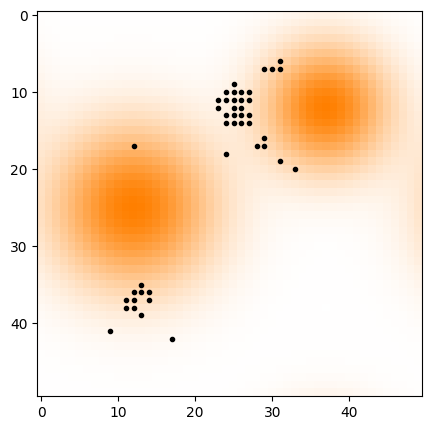

       sugar  metabolism  vision   fitness   x   y
0   1.702323           1       4  1.702323  29  16
1   0.339719           1       5  0.339719  13  36
2   3.722211           1       2  3.722211  26  10
3   3.292726           1       3  3.292726  24  11
4   1.562478           1       4  1.562478  24  10
5   0.267472           1       5  0.267472  24  13
6   2.873136           1       4  2.873136  24  14
7   0.481880           1       4  0.481880  29   7
8   0.551634           1       5  0.551634  26  14
9   3.219088           1       3  3.219088  27  13
10  1.279605           1       5  1.279605  12  36
11  3.810325           1       5  3.810325  26  12
12  4.358152           1       5  4.358152  11  38
13  1.917576           1       4  1.917576  26  11
14  3.566025           1       3  3.566025  14  36
15  2.479232           1       2  2.479232  28  17
16  2.317474           1       2  2.317474  13  39
17  0.663748           1       1  0.663748  17  42
18  3.872483           1       

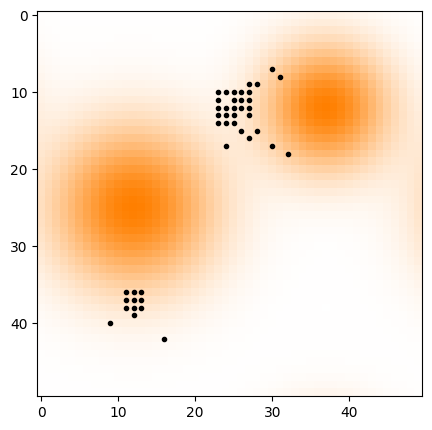

       sugar  metabolism  vision   fitness   x   y
0   2.158133           1       5  2.158133  13  37
1   0.361843           1       4  0.361843  27   9
2   4.358152           1       5  4.358152  12  37
3   0.657042           1       2  0.657042  27  12
4   3.646386           1       2  3.646386  27  10
5   3.969107           1       5  3.969107  13  38
6   1.907409           1       4  1.907409  24  12
7   0.755967           1       1  0.755967  31   8
8   0.186944           1       1  0.186944  16  42
9   1.392812           1       3  1.392812  11  37
10  1.925410           1       4  1.925410  26  11
11  2.434978           1       1  2.434978  24  17
12  3.872359           1       5  3.872359  25  14
13  1.638389           1       3  1.638389  28  15
14  0.042903           1       3  0.042903  32  18
15  3.800161           1       5  3.800161  25  11
16  2.901340           1       5  2.901340  26  12
17  2.300832           1       2  2.300832  27  16
18  2.255375           1       

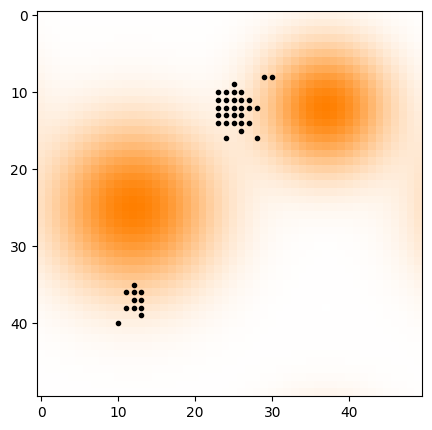

       sugar  metabolism  vision   fitness   x   y
0   2.281161           1       1  2.281161  24  16
1   2.096034           1       5  2.096034  12  35
2   3.370883           1       5  3.370883  24  11
3   0.637217           1       2  0.637217  26  13
4   1.232211           1       5  1.232211  13  37
5   2.749105           1       4  2.749105  23  13
6   1.503797           1       4  1.503797  27  12
7   0.247237           1       5  0.247237  24  13
8   0.745519           1       2  0.745519  25  12
9   1.590156           1       3  1.590156  26  14
10  0.351424           1       3  0.351424  28  16
11  3.761310           1       5  3.761310  25  10
12  4.326713           1       5  4.326713  13  36
13  1.532760           1       4  1.532760  23  14
14  3.814090           1       5  3.814090  25  11
15  0.688877           1       4  0.688877  12  37
16  1.877182           1       4  1.877182  23  11
17  0.749441           1       4  0.749441  26  11
18  2.081928           1       

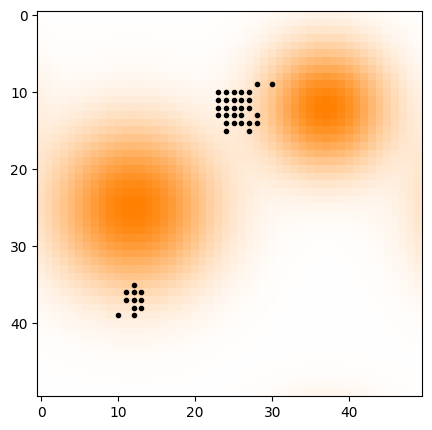

       sugar  metabolism  vision   fitness   x   y
0   0.416318           1       5  0.416318  26  10
1   3.121830           1       3  3.121830  25  14
2   0.266828           1       4  0.266828  26  12
3   3.685486           1       5  3.685486  27  10
4   0.543442           1       2  0.543442  28  13
5   2.645437           1       5  2.645437  26  13
6   1.345205           1       3  1.345205  11  37
7   0.231388           1       3  0.231388  27  15
8   3.823342           1       5  3.823342  25  10
9   0.140825           1       1  0.140825  30   9
10  0.735352           1       2  0.735352  24  12
11  0.749026           1       4  0.749026  25  12
12  3.578323           1       2  3.578323  26  11
13  3.500519           1       5  3.500519  24  10
14  3.322645           1       5  3.322645  27  11
15  2.062108           1       5  2.062108  24  11
16  0.685127           1       2  0.685127  28   9
17  0.643996           1       3  0.643996  13  38
18  2.116413           1       

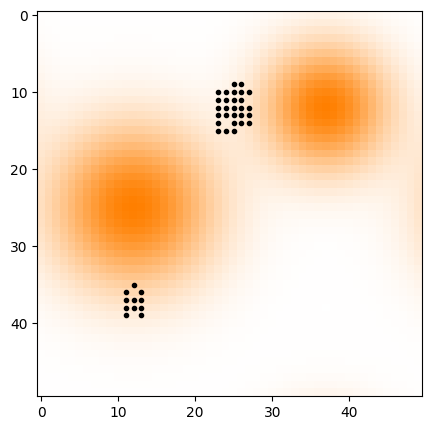

       sugar  metabolism  vision   fitness   x   y
0   2.832772           1       5  2.832772  27  13
1   0.725188           1       2  0.725188  25  11
2   0.406151           1       5  0.406151  24  12
3   1.753151           1       4  1.753151  23  14
4   0.198241           1       5  0.198241  11  38
5   1.283107           1       3  1.283107  12  35
6   1.343150           1       4  1.343150  25  15
7   2.690712           1       4  2.690712  23  13
8   2.039549           1       2  2.039549  13  39
9   3.813177           1       5  3.813177  25  13
10  1.955561           1       1  1.955561  11  39
11  0.155563           1       3  0.155563  27  14
12  3.646635           1       5  3.646635  25  10
13  2.067431           1       1  2.067431  23  15
14  3.452286           1       5  3.452286  26  10
15  2.013886           1       5  2.013886  24  10
16  2.719565           1       3  2.719565  24  15
17  2.056730           1       2  2.056730  26  14
18  0.188560           1       

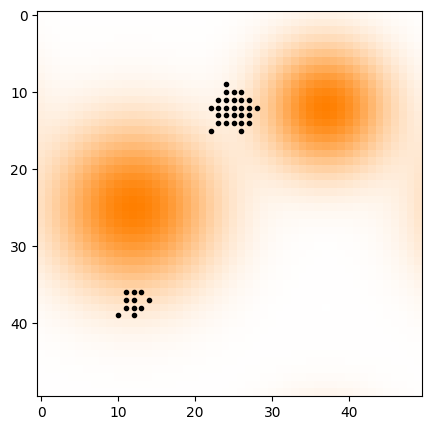

       sugar  metabolism  vision   fitness   x   y
0   2.558358           1       5  2.558358  24  14
1   1.977451           1       2  1.977451  12  39
2   0.367294           1       5  0.367294  23  12
3   3.874258           1       5  3.874258  12  36
4   1.184959           1       5  1.184959  13  36
5   3.803011           1       5  3.803011  24  12
6   0.513452           1       2  0.513452  25  13
7   2.036906           1       2  2.036906  26  13
8   0.676949           1       2  0.676949  27  11
9   1.834198           1       1  1.834198  10  39
10  0.497628           1       2  0.497628  24   9
11  1.905360           1       1  1.905360  22  15
12  2.671332           1       3  2.671332  26  14
13  1.668312           1       4  1.668312  22  12
14  1.454542           1       4  1.454542  25  11
15  0.168735           1       5  0.168735  26  11
16  3.707198           1       5  3.707198  24  11
17  0.198241           1       5  0.198241  12  37
18  1.975035           1       

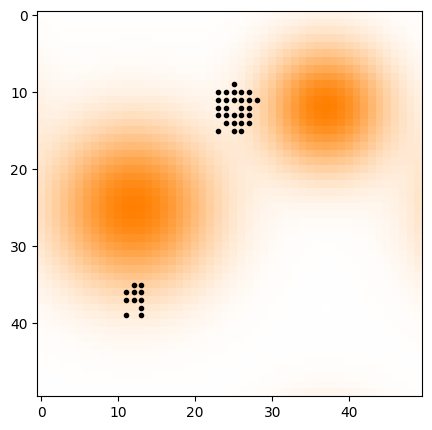

       sugar  metabolism  vision   fitness   x   y
0   2.604718           1       4  2.604718  27  10
1   0.051634           1       3  0.051634  26  12
2   1.219119           1       4  1.219119  23  10
3   0.182286           1       5  0.182286  13  37
4   3.874258           1       5  3.874258  12  37
5   2.586510           1       3  2.586510  25  15
6   2.510130           1       5  2.510130  23  13
7   0.593886           1       4  0.593886  12  36
8   0.120513           1       5  0.120513  24  14
9   1.434717           1       4  1.434717  26  11
10  1.658147           1       4  1.658147  25  11
11  0.534301           1       3  0.534301  12  35
12  1.153520           1       5  1.153520  13  38
13  1.900587           1       2  1.900587  13  39
14  0.583174           1       2  0.583174  28  11
15  2.968966           1       3  2.968966  25   9
16  0.169942           1       4  0.169942  26  14
17  4.231708           1       5  4.231708  13  36
18  1.785368           1       

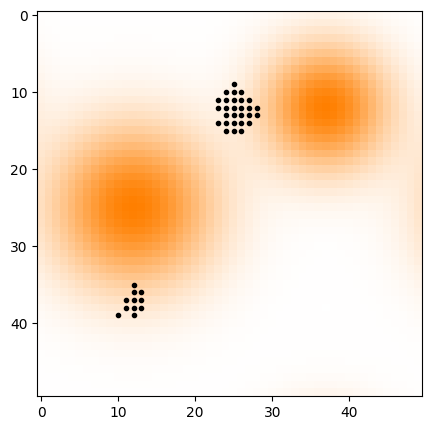

       sugar  metabolism  vision   fitness   x   y
0   1.884773           1       2  1.884773  12  38
1   3.355410           1       5  3.355410  25  12
2   0.270840           1       5  0.270840  26  10
3   3.620119           1       5  3.620119  24  10
4   1.867305           1       2  1.867305  28  13
5   3.520695           1       5  3.520695  23  12
6   1.709565           1       1  1.709565  23  14
7   1.121737           1       5  1.121737  11  38
8   1.666044           1       4  1.666044  25  14
9   2.930116           1       3  2.930116  25  10
10  0.389389           1       2  0.389389  27  14
11  0.072275           1       5  0.072275  27  13
12  3.316201           1       3  3.316201  13  38
13  0.531788           1       4  0.531788  12  39
14  1.916648           1       5  1.916648  24  14
15  3.224975           1       5  3.224975  25  13
16  3.276138           1       2  3.276138  24  15
17  2.000632           1       5  2.000632  12  36
18  0.012772           1       

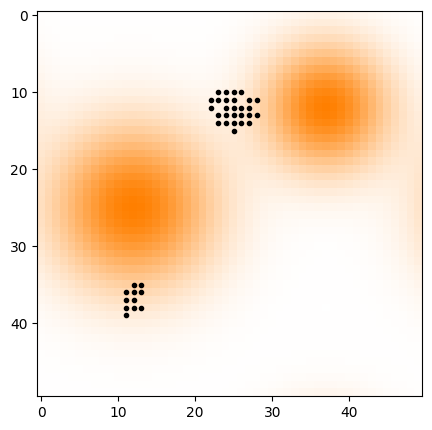

       sugar  metabolism  vision   fitness   x   y
0   1.661337           1       1  1.661337  23  13
1   1.089954           1       5  1.089954  11  36
2   2.613103           1       5  2.613103  23  10
3   1.096193           1       3  1.096193  13  35
4   3.284418           1       3  3.284418  11  38
5   1.969194           1       5  1.969194  13  38
6   2.536660           1       4  2.536660  27  11
7   1.378056           1       3  1.378056  24  11
8   2.919951           1       3  2.919951  25  11
9   2.461113           1       5  2.461113  25  10
10  1.868960           1       2  1.868960  12  36
11  1.773530           1       2  1.773530  28  11
12  1.628160           1       4  1.628160  24  12
13  4.199726           1       5  4.199726  12  38
14  3.600299           1       5  3.600299  24  13
15  3.176753           1       5  3.176753  24  10
16  1.404728           1       4  1.404728  25  13
17  0.404552           1       2  0.404552  28  13
18  1.558015           1       

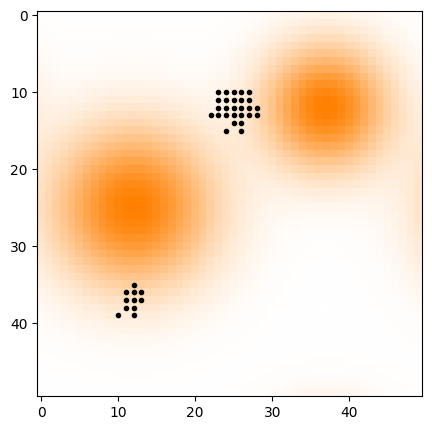

       sugar  metabolism  vision   fitness   x   y
0   2.314189           1       3  2.314189  24  15
1   0.319705           1       2  0.319705  28  12
2   0.502391           1       3  0.502391  13  37
3   0.052035           1       5  0.052035  26  11
4   0.045854           1       4  0.045854  25  12
5   3.137903           1       5  3.137903  25  14
6   1.085271           1       4  1.085271  23  12
7   4.199726           1       5  4.199726  12  37
8   1.853146           1       2  1.853146  12  38
9   2.602934           1       5  2.602934  26  12
10  0.135034           1       5  0.135034  12  36
11  3.749282           1       5  3.749282  13  36
12  1.027856           1       5  1.027856  12  35
13  3.552077           1       5  3.552077  24  10
14  2.460835           1       4  2.460835  27  10
15  0.260018           1       2  0.260018  23  10
16  1.641517           1       1  1.641517  24  13
17  3.424224           1       5  3.424224  27  11
18  2.722575           1       

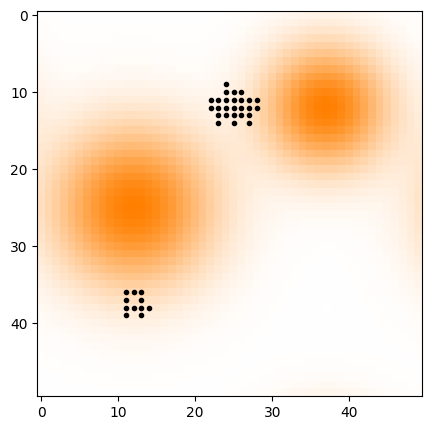

       sugar  metabolism  vision   fitness   x   y
0   0.225929           1       2  0.225929  28  11
1   0.470952           1       3  0.470952  13  38
2   2.646750           1       3  2.646750  27  14
3   0.467882           1       4  0.467882  13  37
4   2.450533           1       5  2.450533  25  12
5   0.041870           1       5  0.041870  25  13
6   2.583110           1       5  2.583110  26  11
7   1.355697           1       4  1.355697  26  12
8   3.666108           1       5  3.666108  27  12
9   0.182967           1       5  0.182967  24  11
10  2.238386           1       3  2.238386  23  14
11  3.239135           1       5  3.239135  26  13
12  1.594908           1       2  1.594908  28  12
13  1.530721           1       4  1.530721  23  11
14  3.375991           1       5  3.375991  26  10
15  3.717499           1       5  3.717499  11  38
16  1.000432           1       4  1.000432  22  12
17  0.273088           1       2  0.273088  27  11
18  3.099046           1       

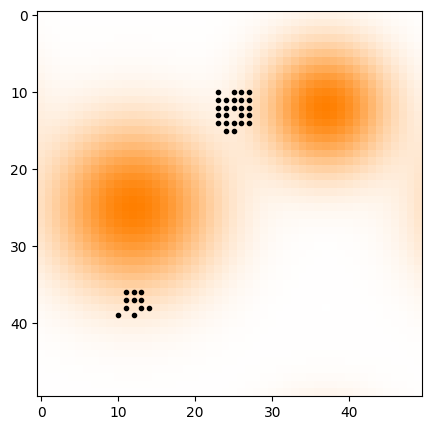

       sugar  metabolism  vision   fitness   x   y
0   1.482499           1       4  1.482499  24  14
1   3.617880           1       5  3.617880  23  11
2   2.544248           1       5  2.544248  27  12
3   3.493402           1       5  3.493402  26  11
4   2.411683           1       5  2.411683  25  10
5   2.861141           1       3  2.861141  25  12
6   0.996417           1       5  0.996417  12  37
7   2.364369           1       4  2.364369  23  13
8   1.641517           1       1  1.641517  24  13
9   2.598517           1       3  2.598517  26  14
10  4.152120           1       5  4.152120  13  36
11  0.224850           1       2  0.224850  27  13
12  3.083071           1       3  3.083071  12  39
13  1.237878           1       1  1.237878  10  39
14  1.530905           1       4  1.530905  27  11
15  3.701331           1       5  3.701331  11  37
16  3.228968           1       5  3.228968  24  12
17  0.163142           1       5  0.163142  26  13
18  2.153564           1       

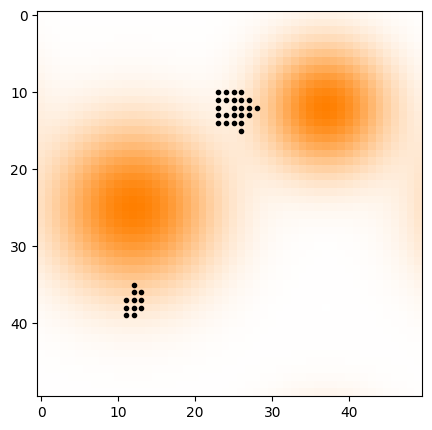

       sugar  metabolism  vision   fitness   x   y
0   1.683318           1       2  1.683318  12  38
1   1.520740           1       4  1.520740  25  13
2   2.812919           1       3  2.812919  24  10
3   1.103479           1       3  1.103479  26  15
4   1.482084           1       4  1.482084  25  12
5   3.288919           1       5  3.288919  24  14
6   0.101866           1       2  0.101866  27  11
7   1.499892           1       2  1.499892  28  12
8   0.025197           1       5  0.025197  12  35
9   1.641517           1       1  1.641517  24  13
10  0.439184           1       3  0.439184  13  37
11  3.067257           1       3  3.067257  12  36
12  0.955060           1       3  0.955060  12  39
13  2.114714           1       3  2.114714  25  14
14  3.013074           1       5  3.013074  26  12
15  2.917193           1       2  2.917193  23  10
16  0.373666           1       4  0.373666  24  11
17  3.445169           1       5  3.445169  26  10
18  2.578692           1       

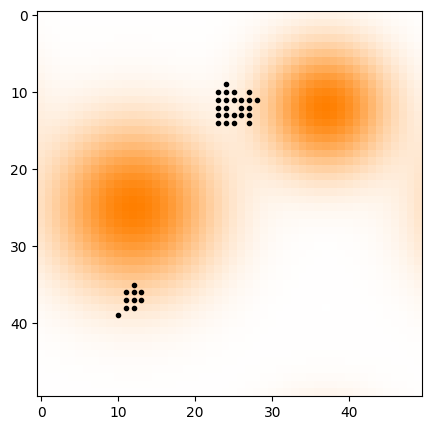

       sugar  metabolism  vision   fitness   x   y
0   2.568526           1       3  2.568526  24  12
1   1.406117           1       2  1.406117  28  11
2   3.035474           1       3  3.035474  11  36
3   2.343620           1       5  2.343620  26  11
4   0.297841           1       4  0.297841  27  10
5   2.993254           1       5  2.993254  24  11
6   0.091697           1       2  0.091697  26  12
7   1.667504           1       2  1.667504  12  36
8   1.641517           1       1  1.641517  24  13
9   4.104867           1       5  4.104867  12  38
10  3.240681           1       5  3.240681  27  13
11  0.137750           1       2  0.137750  27  11
12  2.823455           1       2  2.823455  24   9
13  1.055256           1       3  1.055256  24  14
14  0.837544           1       4  0.837544  23  10
15  1.039104           1       1  1.039104  10  39
16  2.038889           1       3  2.038889  27  14
17  0.377086           1       3  0.377086  12  35
18  2.495233           1       

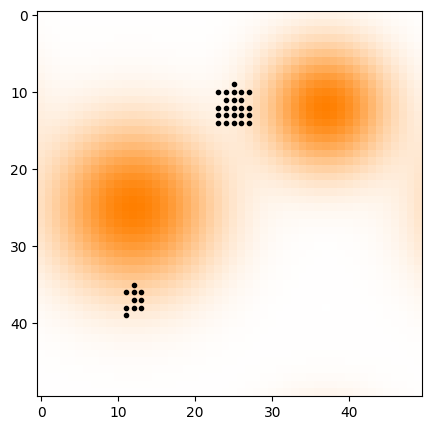

       sugar  metabolism  vision   fitness   x   y
0   3.606670           1       5  3.606670  13  38
1   1.675759           1       5  1.675759  25  12
2   2.529676           1       3  2.529676  25  10
3   0.249608           1       4  0.249608  26  10
4   0.827377           1       4  0.827377  24  12
5   3.004035           1       3  3.004035  13  36
6   1.825695           1       5  1.825695  11  36
7   0.923276           1       3  0.923276  11  38
8   0.949023           1       5  0.949023  12  37
9   1.651549           1       2  1.651549  13  37
10  2.447000           1       5  2.447000  26  14
11  3.386494           1       5  3.386494  25  14
12  2.229884           1       4  2.229884  26  13
13  3.455004           1       5  3.455004  23  10
14  1.433661           1       4  1.433661  24  10
15  3.131425           1       5  3.131425  23  12
16  0.361272           1       3  0.361272  12  36
17  2.000027           1       3  2.000027  27  12
18  4.042769           1       

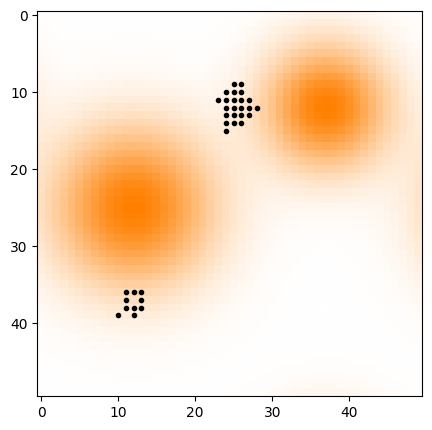

       sugar  metabolism  vision   fitness   x   y
0   2.987867           1       3  2.987867  11  37
1   1.499556           1       1  1.499556  24  15
2   1.794256           1       5  1.794256  13  36
3   0.023634           1       2  0.023634  27  11
4   0.329489           1       3  0.329489  11  36
5   0.388304           1       4  0.388304  12  36
6   0.004665           1       2  0.004665  28  12
7   0.807552           1       4  0.807552  26  11
8   3.590856           1       5  3.590856  12  38
9   1.989861           1       3  1.989861  24  12
10  0.940570           1       3  0.940570  27  12
11  1.097450           1       4  1.097450  24  14
12  3.376325           1       5  3.376325  26  12
13  1.620111           1       2  1.620111  13  38
14  1.385433           1       4  1.385433  23  11
15  2.690410           1       2  2.690410  24  10
16  2.191034           1       4  2.191034  25  14
17  4.026814           1       5  4.026814  13  37
18  0.861178           1       

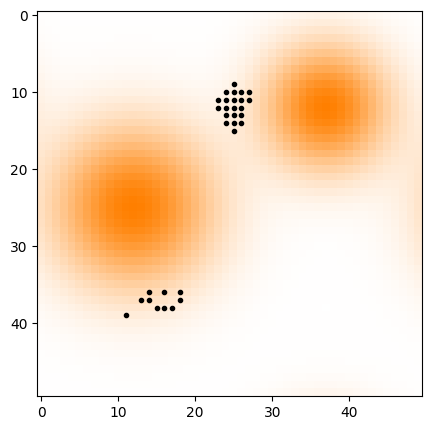

       sugar  metabolism  vision   fitness   x   y
0   3.396331           1       5  3.396331  23  12
1   2.171221           1       4  2.171221  24  11
2   0.774629           1       1  0.774629  11  39
3   3.093874           1       3  3.093874  14  37
4   2.284501           1       5  2.284501  25  14
5   1.979721           1       3  1.979721  25  13
6   1.087291           1       4  1.087291  24  12
7   2.863681           1       5  2.863681  18  36
8   0.135207           1       4  0.135207  27  10
9   0.765093           1       4  0.765093  16  36
10  1.099736           1       5  1.099736  16  38
11  0.449545           1       3  0.449545  14  36
12  4.880250           1       5  4.880250  18  37
13  2.657817           1       3  2.657817  25  10
14  1.717732           1       2  1.717732  15  38
15  3.328184           1       5  3.328184  26  10
16  1.375312           1       4  1.375312  26  12
17  2.642185           1       2  2.642185  23  11
18  2.877028           1       

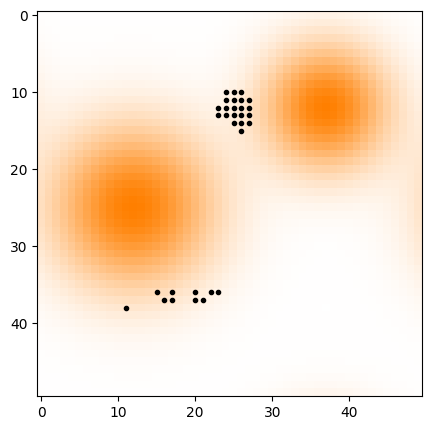

       sugar  metabolism  vision   fitness   x   y
0   1.940994           1       3  1.940994  27  12
1   8.787948           1       5  8.787948  22  36
2   3.110724           1       5  3.110724  25  13
3   2.657420           1       3  2.657420  25  12
4   3.289363           1       5  3.289363  25  10
5   2.368900           1       5  2.368900  27  13
6   2.016159           1       2  2.016159  16  37
7   3.611490           1       3  3.611490  17  37
8   1.103439           1       3  1.103439  17  36
9   1.142919           1       3  1.142919  15  36
10  2.161078           1       4  2.161078  25  11
11  0.816710           1       3  0.816710  27  14
12  0.767936           1       4  0.767936  24  11
13  1.587944           1       5  1.587944  24  13
14  3.162279           1       5  3.162279  26  13
15  2.593968           1       2  2.593968  23  13
16  0.758362           1       1  0.758362  11  38
17  2.348500           1       3  2.348500  26  10
18  1.039249           1       

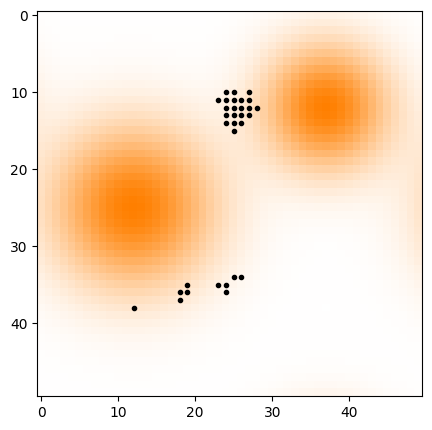

        sugar  metabolism  vision    fitness   x   y
0    1.297140           1       4   1.297140  24  14
1    2.545743           1       2   2.545743  23  11
2    5.244375           1       3   5.244375  19  36
3   15.637606           1       5  15.637606  25  34
4    2.330111           1       5   2.330111  25  14
5    3.114142           1       5   3.114142  27  13
6    3.328400           1       5   3.328400  26  13
7    3.062571           1       5   3.062571  26  14
8    2.943271           1       3   2.943271  19  35
9    1.029109           1       4   1.029109  25  13
10   2.818865           1       5   2.818865  27  11
11   2.869594           1       2   2.869594  18  37
12   2.212344           1       3   2.212344  18  36
13   0.105328           1       4   0.105328  26  12
14  12.422134           1       5  12.422134  24  35
15   1.921236           1       3   1.921236  26  11
16   3.250637           1       5   3.250637  27  12
17   0.776512           1       1   0.776512  

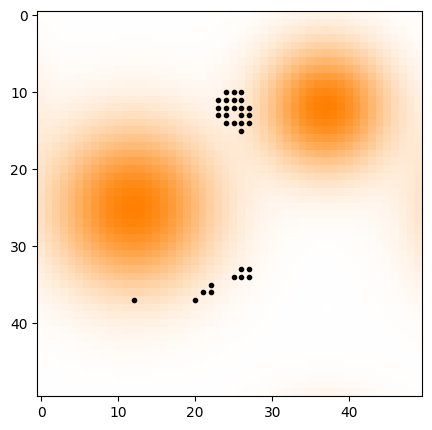

        sugar  metabolism  vision    fitness   x   y
0    3.075289           1       5   3.075289  23  12
1   22.740588           1       5  22.740588  27  33
2    0.057191           1       4   0.057191  27  13
3    3.240516           1       5   3.240516  26  12
4   21.717800           1       5  21.717800  26  33
5    1.510396           1       5   1.510396  27  12
6    3.023750           1       5   3.023750  25  10
7    1.248988           1       4   1.248988  26  14
8    2.497526           1       2   2.497526  23  13
9    2.599136           1       3   2.599136  26  10
10   0.818803           1       1   0.818803  12  37
11   2.187292           1       5   2.187292  25  11
12   0.656524           1       3   0.656524  27  14
13   2.281938           1       5   2.281938  24  14
14  15.367285           1       5  15.367285  26  34
15  19.503509           1       5  19.503509  27  34
16   3.289611           1       5   3.289611  25  14
17   5.321285           1       3   5.321285  

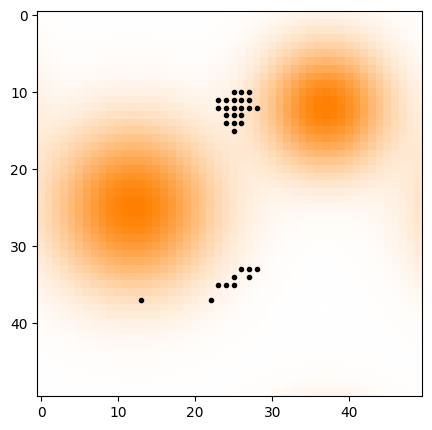

        sugar  metabolism  vision    fitness   x   y
0    2.808328           1       5   2.808328  25  13
1   28.527165           1       5  28.527165  28  33
2    1.248591           1       4   1.248591  25  12
3    0.961152           1       4   0.961152  26  14
4   22.277234           1       4  22.277234  26  33
5   26.353167           1       5  26.353167  25  34
6   13.803517           1       3  13.803517  25  35
7    3.055486           1       5   3.055486  24  13
8    2.243085           1       5   2.243085  23  12
9    2.139249           1       5   2.139249  27  11
10   7.941851           1       2   7.941851  22  37
11  29.821963           1       5  29.821963  27  34
12   1.286981           1       4   1.286981  25  11
13   2.975576           1       5   2.975576  24  14
14   2.092285           1       4   2.092285  25  10
15   2.579324           1       3   2.579324  24  11
16   3.241470           1       5   3.241470  26  10
17   1.862668           1       3   1.862668  

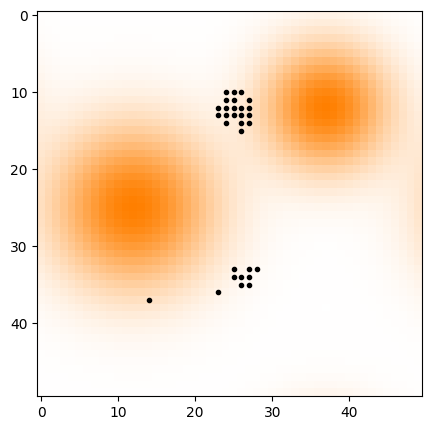

        sugar  metabolism  vision    fitness   x   y
0    2.044071           1       4   2.044071  24  10
1    2.204264           1       5   2.204264  25  10
2    3.191504           1       5   3.191504  23  12
3    1.276822           1       4   1.276822  24  12
4   20.918320           1       3  20.918320  26  34
5    2.569180           1       3   2.569180  25  11
6   36.614394           1       5  36.614394  25  33
7   33.434542           1       5  33.434542  27  34
8   29.319925           1       5  29.319925  25  34
9    0.913015           1       4   0.913015  27  13
10   0.965013           1       1   0.965013  26  15
11   1.228778           1       4   1.228778  24  11
12   3.055089           1       5   3.055089  25  12
13  17.239419           1       3  17.239419  26  35
14   2.955773           1       5   2.955773  24  13
15   2.760175           1       5   2.760175  26  14
16  35.630147           1       5  35.630147  27  33
17  29.086598           1       4  29.086598  

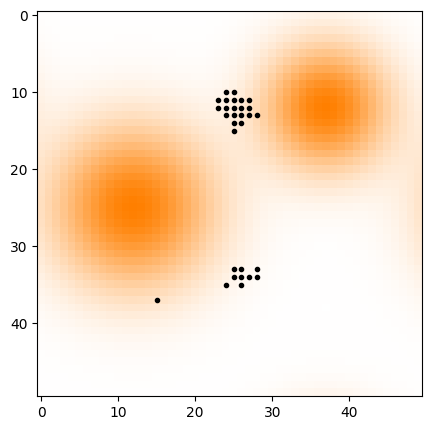

        sugar  metabolism  vision    fitness   x   y
0    2.549422           1       3   2.549422  26  11
1    1.167531           1       1   1.167531  15  37
2   28.014134           1       3  28.014134  26  33
3   40.549345           1       5  40.549345  26  34
4    2.090999           1       3   2.090999  25  11
5    0.880376           1       1   0.880376  25  15
6    1.189989           1       4   1.189989  25  14
7    3.171692           1       5   3.171692  24  11
8   36.401300           1       5  36.401300  27  34
9    1.237969           1       4   1.237969  23  12
10   0.940536           1       2   0.940536  28  13
11   0.902856           1       4   0.902856  24  12
12  43.464051           1       5  43.464051  25  34
13   3.035310           1       5   3.035310  26  13
14  18.547691           1       2  18.547691  24  35
15   2.203867           1       5   2.203867  25  12
16   2.352858           1       2   2.352858  23  11
17  24.031850           1       3  24.031850  

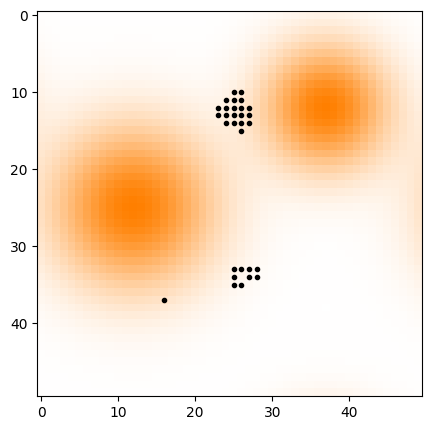

        sugar  metabolism  vision    fitness   x   y
0    1.985810           1       4   1.985810  26  10
1   42.841237           1       4  42.841237  27  33
2    1.227849           1       4   1.227849  26  12
3    1.355491           1       5   1.355491  23  12
4    0.854704           1       4   0.854704  26  14
5    1.822585           1       3   1.822585  24  12
6    3.151888           1       5   3.151888  24  13
7    2.184054           1       5   2.184054  24  11
8   30.683506           1       3  30.683506  26  35
9   50.256482           1       5  50.256482  25  33
10   0.457215           1       3   0.457215  25  12
11  34.863792           1       3  34.863792  25  34
12   2.052272           1       3   2.052272  27  12
13  49.535326           1       5  49.535326  26  33
14  43.210665           1       5  43.210665  28  33
15   2.701895           1       5   2.701895  25  11
16   3.135150           1       5   3.135150  27  13
17   1.141816           1       4   1.141816  

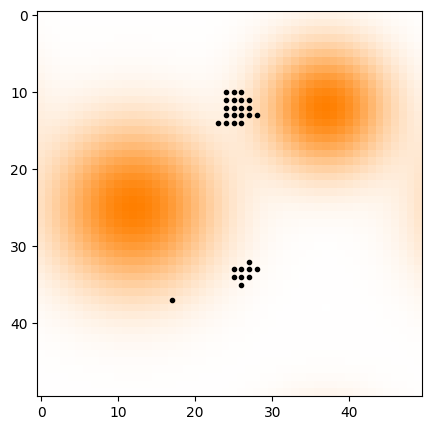

        sugar  metabolism  vision    fitness   x   y
0    2.463518           1       3   2.463518  23  14
1    0.844564           1       4   0.844564  25  13
2    1.774371           1       3   1.774371  24  10
3    2.031763           1       5   2.031763  24  12
4    0.738678           1       1   0.738678  26  14
5   56.650129           1       5  56.650129  26  34
6   50.306478           1       5  50.306478  26  33
7    2.164275           1       5   2.164275  26  13
8    1.122003           1       4   1.122003  24  11
9   49.650601           1       4  49.650601  28  33
10   0.554350           1       4   0.554350  27  11
11  41.966774           1       3  41.966774  27  33
12   2.663074           1       5   2.663074  25  10
13   0.447072           1       3   0.447072  25  11
14   3.151491           1       5   3.151491  25  12
15   0.771302           1       2   0.771302  28  13
16  57.106140           1       5  57.106140  25  34
17   2.995748           1       5   2.995748  

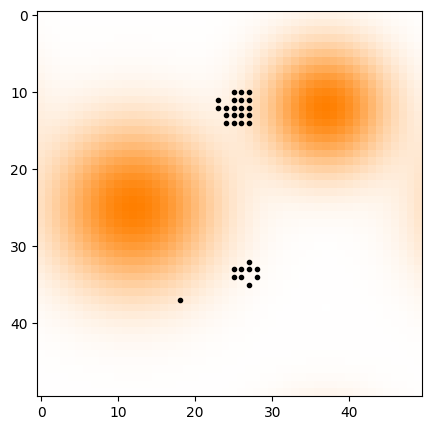

        sugar  metabolism  vision    fitness   x   y
0   56.401455           1       4  56.401455  28  34
1    1.169237           1       4   1.169237  23  12
2   44.285301           1       3  44.285301  28  33
3    2.643315           1       5   2.643315  26  11
4    1.277881           1       5   1.277881  25  10
5    3.048220           1       5   3.048220  25  14
6    1.928585           1       3   1.928585  27  10
7   63.898571           1       5  63.898571  25  33
8    2.819980           1       5   2.819980  27  13
9   63.499787           1       5  63.499787  25  34
10  49.286335           1       3  49.286335  26  34
11   2.957021           1       5   2.957021  27  12
12   2.144472           1       5   2.144472  24  13
13  48.610216           1       3  48.610216  27  32
14   0.718899           1       1   0.718899  26  13
15  38.219926           1       2  38.219926  27  35
16   0.695594           1       2   0.695594  27  14
17   0.796423           1       4   0.796423  

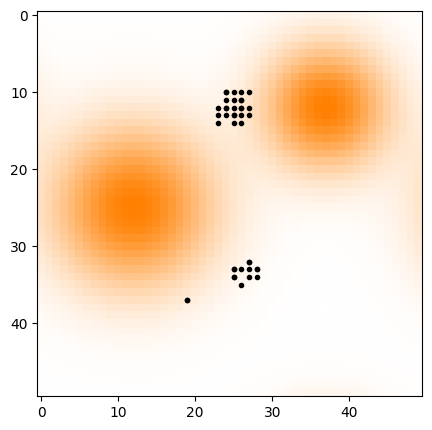

        sugar  metabolism  vision    fitness     x     y
0    1.945737         1.0     4.0   1.945737  24.0  11.0
1    2.809840         1.0     5.0   2.809840  25.0  13.0
2    1.073469         1.0     4.0   1.073469  27.0  13.0
3    2.956624         1.0     5.0   2.956624  25.0  12.0
4    2.367128         1.0     3.0   2.367128  23.0  13.0
5   64.490835         1.0     5.0  64.490835  27.0  34.0
6   70.602769         1.0     5.0  70.602769  27.0  33.0
7   44.871582         1.0     2.0  44.871582  26.0  35.0
8    3.009494         1.0     5.0   3.009494  27.0  12.0
9    3.102543         1.0     5.0   3.102543  25.0  14.0
10  63.251113         1.0     4.0  63.251113  25.0  34.0
11  51.036155         1.0     3.0  51.036155  28.0  34.0
12   1.880371         1.0     3.0   1.880371  24.0  10.0
13   0.534048         1.0     4.0   0.534048  24.0  12.0
14   1.159094         1.0     4.0   1.159094  25.0  11.0
15   0.398099         1.0     3.0   0.398099  23.0  12.0
16  55.419581         1.0     3

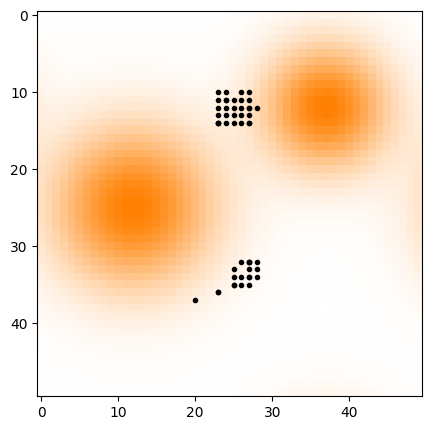

        sugar  metabolism  vision    fitness     x     y
0    2.761797         1.0     5.0   2.761797  27.0  11.0
1    1.148954         1.0     4.0   1.148954  25.0  13.0
2    6.037671         1.0     1.0   6.037671  20.0  37.0
3   70.365916         1.0     4.0  70.365916  26.0  34.0
4   77.452427         1.0     5.0  77.452427  25.0  34.0
5    0.710729         1.0     4.0   0.710729  25.0  11.0
6    1.025296         1.0     4.0   1.025296  24.0  14.0
7    1.209986         1.0     3.0   1.209986  27.0  13.0
8    1.602156         1.0     3.0   1.602156  23.0  11.0
9   62.522563         1.0     5.0  62.522563  27.0  33.0
10   2.989736         1.0     5.0   2.989736  26.0  11.0
11   0.495322         1.0     5.0   0.495322  27.0  12.0
12   1.247964         1.0     5.0   1.247964  24.0  12.0
13   1.804821         1.0     3.0   1.804821  27.0  10.0
14   2.291364         1.0     3.0   2.291364  23.0  14.0
15   0.349885         1.0     3.0   0.349885  24.0  10.0
16  62.228946         1.0     3

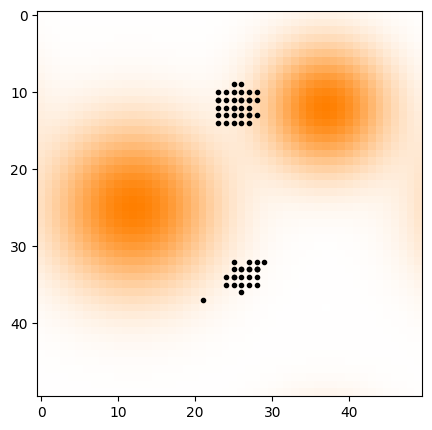

        sugar  metabolism  vision    fitness     x     y
0    1.116756         1.0     3.0   1.116756  28.0  11.0
1   77.461729         1.0     4.0  77.461729  26.0  33.0
2    8.567625         1.0     1.0   8.567625  21.0  37.0
3   69.845224         1.0     3.0  69.845224  26.0  34.0
4   69.174219         1.0     5.0  69.174219  26.0  35.0
5    2.751215         1.0     4.0   2.751215  25.0  10.0
6    2.536582         1.0     5.0   2.536582  24.0  13.0
7    0.265102         1.0     3.0   0.265102  25.0   9.0
8    3.024901         1.0     5.0   3.024901  25.0  14.0
9    0.986443         1.0     4.0   0.986443  23.0  12.0
10   0.662592         1.0     4.0   0.662592  27.0  13.0
11   1.592013         1.0     3.0   1.592013  25.0  11.0
12  15.105631         1.0     5.0  15.105631  24.0  34.0
13  84.555409         1.0     5.0  84.555409  27.0  33.0
14   2.197799         1.0     2.0   2.197799  25.0  12.0
15  84.925417         1.0     5.0  84.925417  25.0  34.0
16  81.845646         1.0     5

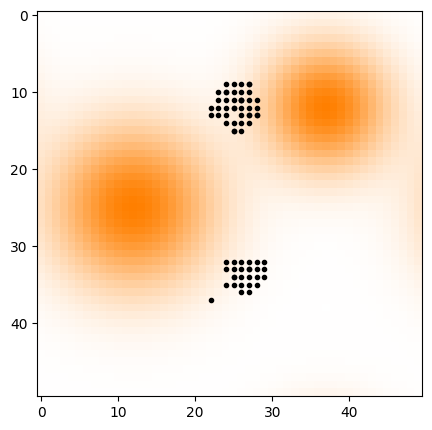

        sugar  metabolism  vision    fitness     x     y
0   13.756776         1.0     5.0  13.756776  26.0  32.0
1   63.495899         1.0     2.0  63.495899  24.0  33.0
2    1.690290         1.0     3.0   1.690290  24.0   9.0
3    0.578114         1.0     4.0   0.578114  28.0  12.0
4    1.180014         1.0     5.0   1.180014  27.0  13.0
..        ...         ...     ...        ...   ...   ...
64   1.023229         1.0     2.0   1.023229  27.0   9.0
65   1.572254         1.0     3.0   1.572254  26.0  11.0
66   0.577956         1.0     4.0   0.577956  25.0  15.0
67   2.685600         1.0     5.0   2.685600  25.0  12.0
68   1.572254         1.0     3.0   1.572254  26.0  11.0

[69 rows x 6 columns]
        sugar  metabolism  vision  fitness     x     y
0    0.903954         1.0     2.0      0.0  28.0  10.0
1    2.450642         1.0     5.0      0.0  25.0  13.0
2   97.151055         1.0     3.0      0.0  29.0  35.0
3   82.434527         1.0     3.0      0.0  24.0  34.0
4   28.607915     

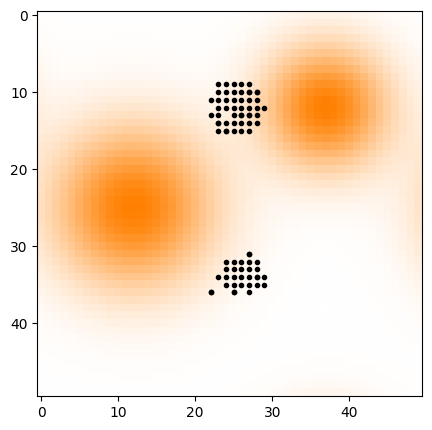

        sugar  metabolism  vision    fitness     x     y
0    0.903954         1.0     2.0   0.903954  28.0  10.0
1    2.450642         1.0     5.0   2.450642  25.0  13.0
2   97.151055         1.0     3.0  97.151055  29.0  35.0
3   82.434527         1.0     3.0  82.434527  24.0  34.0
4   28.607915         1.0     5.0  28.607915  27.0  35.0
..        ...         ...     ...        ...   ...   ...
74   0.141414         1.0     2.0   0.141414  28.0  10.0
75  93.247574         1.0     5.0  93.247574  27.0  31.0
76   2.690964         1.0     3.0   2.690964  24.0  15.0
77   2.609836         1.0     1.0   2.609836  27.0  10.0
78   1.496704         1.0     5.0   1.496704  23.0  14.0

[79 rows x 6 columns]
         sugar  metabolism  vision  fitness     x     y
0     2.617754         1.0     5.0      0.0  24.0  13.0
1     0.373254         1.0     4.0      0.0  22.0  12.0
2     1.707052         1.0     2.0      0.0  27.0  11.0
3     1.935651         1.0     3.0      0.0  22.0  14.0
4   105.07449

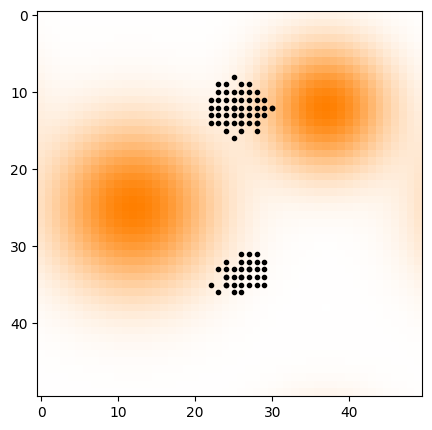

         sugar  metabolism  vision     fitness     x     y
0     2.617754         1.0     5.0    2.617754  24.0  13.0
1     0.373254         1.0     4.0    0.373254  22.0  12.0
2     1.707052         1.0     2.0    1.707052  27.0  11.0
3     1.935651         1.0     3.0    1.935651  22.0  14.0
4   105.074492         1.0     5.0  105.074492  29.0  33.0
..         ...         ...     ...         ...   ...   ...
84  100.559395         1.0     4.0  100.559395  27.0  33.0
85   98.464777         1.0     4.0   98.464777  26.0  34.0
86    1.859233         1.0     2.0    1.859233  30.0  12.0
87   91.932012         1.0     5.0   91.932012  24.0  14.0
88    2.853883         1.0     5.0    2.853883  26.0  14.0

[89 rows x 6 columns]
         sugar  metabolism  vision  fitness     x     y
0    95.808918         1.0     3.0      0.0  25.0  32.0
1    37.234359         1.0     5.0      0.0  26.0  33.0
2    93.293123         1.0     3.0      0.0  23.0  34.0
3   101.625666         1.0     5.0      0.0  

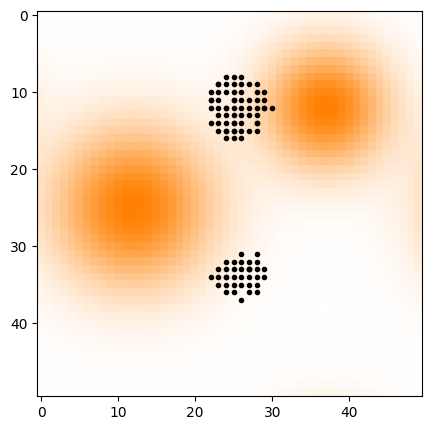

         sugar  metabolism  vision     fitness     x     y
0    95.808918         1.0     3.0   95.808918  25.0  32.0
1    37.234359         1.0     5.0   37.234359  26.0  33.0
2    93.293123         1.0     3.0   93.293123  23.0  34.0
3   101.625666         1.0     5.0  101.625666  25.0  15.0
4   107.640770         1.0     4.0  107.640770  27.0  34.0
..         ...         ...     ...         ...   ...   ...
93    0.425650         3.0     1.0    0.425650  27.0  33.0
94    1.770482         1.0     4.0    1.770482  25.0  14.0
95    0.704701         1.0     4.0    0.704701  23.0   9.0
96  101.625666         1.0     5.0  101.625666  25.0  15.0
97    0.056915         1.0     2.0    0.056915  28.0  14.0

[98 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0      0.137096         1.0     4.0      0.0  24.0  11.0
1     46.119383         1.0     5.0      0.0  26.0  36.0
2     15.085812         1.0     5.0      0.0  25.0  35.0
3      0.061758         1.0     5.0      

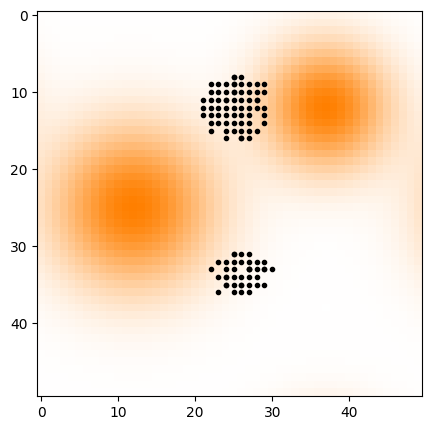

          sugar  metabolism  vision     fitness     x     y
0      0.137096         1.0     4.0    0.137096  24.0  11.0
1     46.119383         1.0     5.0   46.119383  26.0  36.0
2     15.085812         1.0     5.0   15.085812  25.0  35.0
3      0.061758         1.0     5.0    0.061758  27.0  10.0
4      0.071474         1.0     5.0    0.071474  27.0  14.0
..          ...         ...     ...         ...   ...   ...
100  111.966091         1.0     5.0  111.966091  24.0  35.0
101    2.308631         1.0     4.0    2.308631  24.0  11.0
102    0.137096         1.0     3.0    0.137096  26.0  16.0
103   91.844965         1.0     4.0   91.844965  25.0  10.0
104    0.137187         1.0     5.0    0.137187  28.0  11.0

[105 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0     22.181625         1.0     5.0      0.0  26.0  33.0
1    108.579845         1.0     5.0      0.0  25.0  35.0
2      1.237122         1.0     3.0      0.0  23.0   8.0
3     33.609668         1.0 

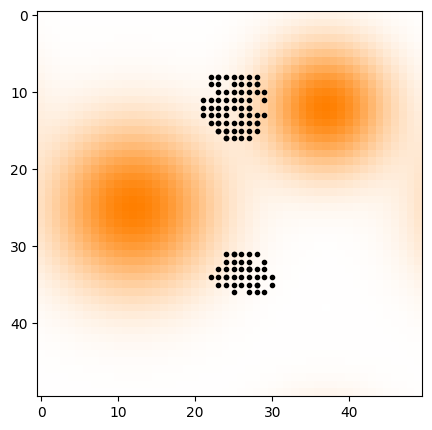

          sugar  metabolism  vision     fitness     x     y
0     22.181625         1.0     5.0   22.181625  26.0  33.0
1    108.579845         1.0     5.0  108.579845  25.0  35.0
2      1.237122         1.0     3.0    1.237122  23.0   8.0
3     33.609668         1.0     5.0   33.609668  29.0  34.0
4      2.878506         1.0     5.0    2.878506  23.0  11.0
..          ...         ...     ...         ...   ...   ...
105    1.677914         1.0     4.0    1.677914  23.0  15.0
106   49.432215         1.0     4.0   49.432215  28.0  35.0
107    1.033060         1.0     3.0    1.033060  24.0  16.0
108    0.198928         1.0     5.0    0.198928  28.0   9.0
109    2.776222         1.0     2.0    2.776222  27.0  12.0

[110 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0    121.630388         1.0     5.0      0.0  26.0  36.0
1      0.042320         1.0     3.0      0.0  25.0  13.0
2      0.958750         1.0     3.0      0.0  22.0  15.0
3     60.933263         1.0 

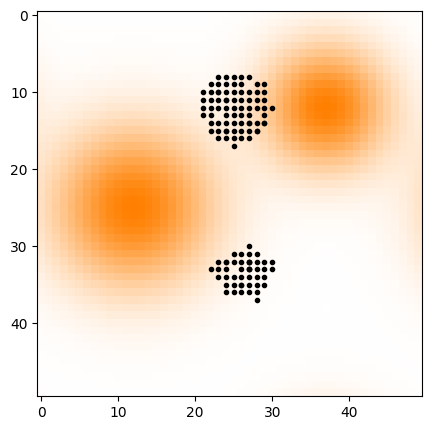

          sugar  metabolism  vision     fitness     x     y
0    121.630388         1.0     5.0  121.630388  26.0  36.0
1      0.042320         1.0     3.0    0.042320  25.0  13.0
2      0.958750         1.0     3.0    0.958750  22.0  15.0
3     60.933263         1.0     5.0   60.933263  28.0  32.0
4      0.371790         1.0     4.0    0.371790  24.0   9.0
..          ...         ...     ...         ...   ...   ...
115   28.825068         1.0     5.0   28.825068  27.0  32.0
116    1.517453         1.0     5.0    1.517453  24.0  11.0
117  101.436610         1.0     5.0  101.436610  27.0  14.0
118    0.068889         1.0     5.0    0.068889  24.0  15.0
119   28.825068         1.0     5.0   28.825068  27.0  32.0

[120 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0      2.164504         1.0     5.0      0.0  23.0  13.0
1      0.477550         1.0     2.0      0.0  23.0  10.0
2      0.207799         1.0     3.0      0.0  24.0  13.0
3     64.768422         1.0 

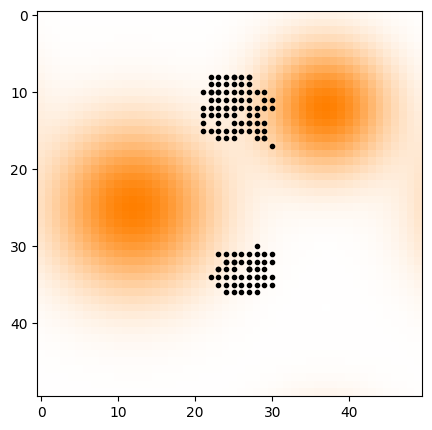

          sugar  metabolism  vision     fitness     x     y
0      2.164504         1.0     5.0    2.164504  23.0  13.0
1      0.477550         1.0     2.0    0.477550  23.0  10.0
2      0.207799         1.0     3.0    0.207799  24.0  13.0
3     64.768422         1.0     5.0   64.768422  25.0  33.0
4      0.636875         1.0     5.0    0.636875  21.0  14.0
..          ...         ...     ...         ...   ...   ...
121  101.426754         1.0     5.0  101.426754  24.0  12.0
122   20.258385         1.0     5.0   20.258385  28.0  34.0
123    2.612972         1.0     4.0    2.612972  22.0  10.0
124  114.222741         1.0     5.0  114.222741  23.0  33.0
125    2.084383         1.0     3.0    2.084383  25.0   8.0

[126 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0     70.051087         1.0     5.0      0.0  26.0  33.0
1    139.877429         1.0     5.0      0.0  29.0  36.0
2      0.671328         1.0     3.0      0.0  24.0  14.0
3     51.532168         1.0 

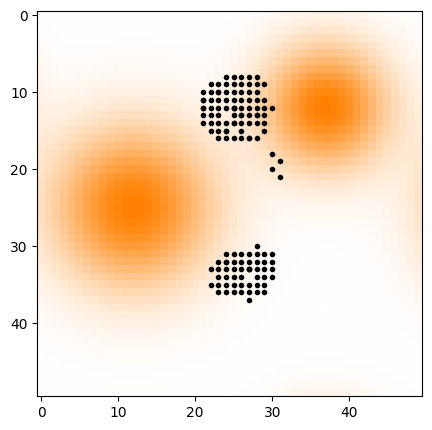

          sugar  metabolism  vision     fitness     x     y
0     70.051087         1.0     5.0   70.051087  26.0  33.0
1    139.877429         1.0     5.0  139.877429  29.0  36.0
2      0.671328         1.0     3.0    0.671328  24.0  14.0
3     51.532168         1.0     3.0   51.532168  28.0  32.0
4    113.013297         1.0     5.0  113.013297  27.0  33.0
..          ...         ...     ...         ...   ...   ...
128    1.688248         1.0     5.0    1.688248  27.0  16.0
129   73.630155         1.0     3.0   73.630155  23.0  10.0
130    0.042567         1.0     3.0    0.042567  25.0  12.0
131   23.388012         1.0     4.0   23.388012  24.0  32.0
132    0.169809         1.0     2.0    0.169809  21.0  11.0

[133 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0     48.983381         1.0     5.0      0.0  27.0  34.0
1     85.367507         1.0     5.0      0.0  24.0  13.0
2    130.596527         1.0     5.0      0.0  25.0  33.0
3      0.976411         1.0 

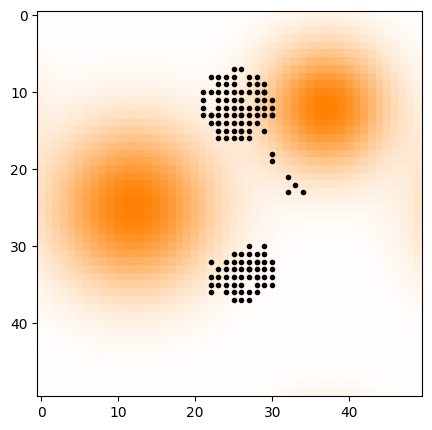

          sugar  metabolism  vision     fitness     x     y
0     48.983381         1.0     5.0   48.983381  27.0  34.0
1     85.367507         1.0     5.0   85.367507  24.0  13.0
2    130.596527         1.0     5.0  130.596527  25.0  33.0
3      0.976411         1.0     4.0    0.976411  25.0  14.0
4    124.157720         1.0     3.0  124.157720  22.0  34.0
..          ...         ...     ...         ...   ...   ...
130    1.555907         1.0     1.0    1.555907  30.0  13.0
131  101.266794         1.0     5.0  101.266794  23.0  14.0
132    1.260038         1.0     3.0    1.260038  22.0  13.0
133    1.377578         1.0     2.0    1.377578  29.0  10.0
134    1.422249         1.0     5.0    1.422249  26.0  13.0

[135 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0     77.390024         1.0     4.0      0.0  27.0  11.0
1     73.318893         1.0     3.0      0.0  22.0  11.0
2      1.453408         1.0     3.0      0.0  28.0  15.0
3      8.966450         1.0 

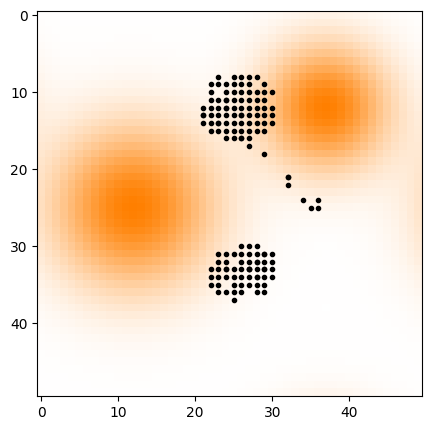

          sugar  metabolism  vision     fitness     x     y
0     77.390024         1.0     4.0   77.390024  27.0  11.0
1     73.318893         1.0     3.0   73.318893  22.0  11.0
2      1.453408         1.0     3.0    1.453408  28.0  15.0
3      8.966450         1.0     5.0    8.966450  35.0  25.0
4      1.151622         1.0     2.0    1.151622  30.0  10.0
..          ...         ...     ...         ...   ...   ...
137   91.355486         1.0     5.0   91.355486  24.0  12.0
138  124.917405         1.0     3.0  124.917405  26.0  16.0
139    0.359707         1.0     5.0    0.359707  29.0  31.0
140  156.157711         1.0     5.0  156.157711  24.0  33.0
141    2.758186         1.0     5.0    2.758186  32.0  21.0

[142 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0    122.673655         1.0     2.0      0.0  24.0  35.0
1     65.459344         1.0     3.0      0.0  23.0  35.0
2    124.754455         1.0     3.0      0.0  28.0  16.0
3    119.927788         1.0 

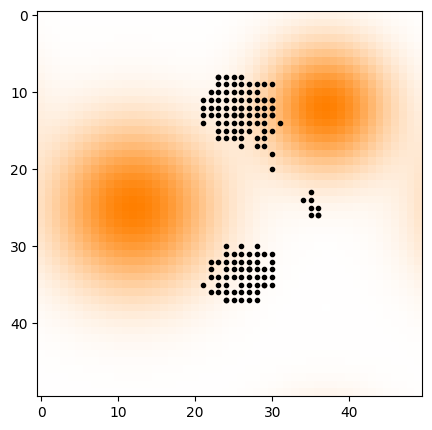

          sugar  metabolism  vision     fitness     x     y
0    122.673655         1.0     2.0  122.673655  24.0  35.0
1     65.459344         1.0     3.0   65.459344  23.0  35.0
2    124.754455         1.0     3.0  124.754455  28.0  16.0
3    119.927788         1.0     2.0  119.927788  24.0  37.0
4     14.179843         1.0     5.0   14.179843  36.0  26.0
..          ...         ...     ...         ...   ...   ...
146    6.051449         1.0     5.0    6.051449  29.0  35.0
147    1.455634         1.0     4.0    1.455634  30.0  13.0
148    1.492453         1.0     5.0    1.492453  26.0  12.0
149    0.623304         1.0     2.0    0.623304  23.0   8.0
150    1.068686         1.0     3.0    1.068686  30.0  12.0

[151 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0      1.282083         1.0     5.0      0.0  22.0  14.0
1    157.770930         1.0     4.0      0.0  25.0  35.0
2     10.947519         1.0     5.0      0.0  36.0  24.0
3      0.771159         1.0 

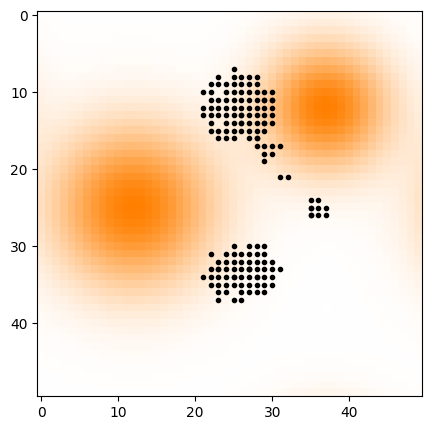

          sugar  metabolism  vision     fitness     x     y
0      1.282083         1.0     5.0    1.282083  22.0  14.0
1    157.770930         1.0     4.0  157.770930  25.0  35.0
2     10.947519         1.0     5.0   10.947519  36.0  24.0
3      0.771159         1.0     4.0    0.771159  26.0  15.0
4      0.299261         1.0     2.0    0.299261  29.0  19.0
..          ...         ...     ...         ...   ...   ...
154   75.034897         1.0     5.0   75.034897  28.0  34.0
155    0.862067         1.0     4.0    0.862067  26.0  14.0
156    0.209660         1.0     2.0    0.209660  30.0  11.0
157    1.729274         1.0     2.0    1.729274  28.0  16.0
158    0.200186         1.0     4.0    0.200186  29.0  14.0

[159 rows x 6 columns]
          sugar  metabolism  vision  fitness     x     y
0    174.017357         1.0     5.0      0.0  25.0  36.0
1      0.791510         1.0     2.0      0.0  26.0  13.0
2      1.672577         1.0     5.0      0.0  23.0  14.0
3     14.191609         1.0 

In [13]:
import time
from tkinter import Tk
from tkinter import Canvas
import numpy as np

from colour import Color
white = Color("white")
cell_color_list = list(white.range_to(Color("orange"), max_sugar))

print(cell_color_list)

r0 = 0.25
N_skip = 1

# Visualize status every N_skip steps. 
window_size = 600

# Define the RGB colors for white and orange
RGB1 = [1.0, 0.5, 0.0]  # Orange for high values.
RGB0 = [1.0, 1.0, 1.0]  # White for low values.


# Normalize sugar array
normalized_sugar = SuSca / max_sugar  # Normalize to [0, 1]

# Convert the sugar array to RGB colors
color_image = convert2RGB(normalized_sugar, RGB0, RGB1)

tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
canvas.place(x=10, y=10, height=window_size, width=window_size)

# cell_color_list = ['#FFFFFF', '#FFECCE', '#FFCE88', '#FFA040', '#FF8000']

step = 0

def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
running = True  # Flag to control the loop.

while running:

    nSuSca, nA = move_agents(SuSca, agents, N)  # Move the agents on the sugarscape.

    # Update animation frame.
    if step % N_skip == 0:
        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(agents["x"], agents["y"], '.', color='k')
        plt.show()
        
        canvas.delete('all')
        SU_cells = []

        # Normalize sugar array
        normalized_sugar = nSuSca / max_sugar  # Normalize to [0, 1]

        # Convert the sugar array to RGB colors
        color_image = convert2RGB(normalized_sugar, RGB0, RGB1)

        # Use the converted RGB image to draw the cells
        for i in range(N):
            for j in range(N):
                # Get the color from the RGB image
                cell_color = color_image[i, j]
                hex_color = f'#{int(cell_color[0]*255):02x}{int(cell_color[1]*255):02x}{int(cell_color[2]*255):02x}'
                
                SU_cells.append(
                    canvas.create_rectangle(
                        i / N * window_size, 
                        j / N * window_size,
                        (i + 1) / N * window_size,
                        (j + 1) / N * window_size, 
                        outline='', 
                        fill=hex_color,
                    )
                )

        # Update the agents
        Agents_circ = []
        for _, agent in agents.iterrows():  # Iterating through each row in the DataFrame
            x = agent["x"]  # X-coordinate of the agent
            y = agent["y"]  # Y-coordinate of the agent

            # Drawing the agent as a circle
            Agents_circ.append(
                canvas.create_oval(
                    (x + 0.5 - r0) / N * window_size,  # Top-left x-coordinate
                    (y + 0.5 - r0) / N * window_size,  # Top-left y-coordinate
                    (x + 0.5 + r0) / N * window_size,  # Bottom-right x-coordinate
                    (y + 0.5 + r0) / N * window_size,  # Bottom-right y-coordinate
                    outline='', 
                    fill='#000000',
                )
            )

        tk.title(f'Iteration {step}')
        tk.update_idletasks()
        tk.update()
        time.sleep(0.5)  # Increase to slow down the simulation.

    agents['fitness'] = agents.apply(calculate_fitness, axis=1)
    print(agents)


    agents = nA
    step += 1 
    
    # after some steps, apply the GA logic
    if step >30:
        parents = select_parents(agents, 10)
        new_agents = []
        for i in range(0, len(parents), 2):
            parent1 = parents.iloc[i]
            parent2 = parents.iloc[i + 1]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_agents.append(child1)
            new_agents.append(child2)
        agents = replace_population(agents, pd.DataFrame(new_agents))  # Keeping the old agents and adding the new ones to the population --> Population size grows each round
        print(agents)
    
    # Periodically regenerate sugar hotspots
    if step % 20 == 0:  # Regenerate every 20 steps
        SuSca = regenerate_hotspots(SuSca, N=50, num_hotspots=3, max_sugar=10, peak_value=5, sigma=4)


tk.update_idletasks()
tk.update()
tk.mainloop()  # Release animation handle (close window to finish).


In [14]:
# import time
# from tkinter import Tk, Canvas
# import numpy as np
# import pandas as pd  # Assuming agents are stored in a DataFrame

# # Parameters
# r0 = 0.25
# N_skip = 1
# window_size = 600
# RGB1 = [1.0, 0.5, 0.0]  # Orange for high sugar
# RGB0 = [1.0, 1.0, 1.0]  # White for low sugar

# def convert2RGB(game_outcome, RGB0, RGB1):
#     """
#     Convert the sugar levels into an RGB color map dynamically.
#     """
#     game_outcome -= np.amin(game_outcome)
#     game_outcome /= np.amax(game_outcome)
#     I_RGB = np.zeros((*game_outcome.shape, 3))
#     for c in range(3):
#         I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]
#     return I_RGB

# # Function to dynamically update the canvas
# def update_canvas(canvas, SuSca, agents, SU_cells, Agents_circ, N, window_size):
#     """
#     Update the canvas dynamically for Sugarscape and agents.
#     """
#     # Normalize sugar levels for RGB mapping
#     normalized_sugar = SuSca / np.max(SuSca)
#     color_image = convert2RGB(normalized_sugar, RGB0, RGB1)

#     # Clear old sugar cells
#     for cell in SU_cells:
#         canvas.delete(cell)
#     SU_cells.clear()

#     # Update Sugarscape
#     for i in range(N):
#         for j in range(N):
#             if SuSca[i, j] > 0:
#                 cell_color = color_image[i, j]
#                 hex_color = f'#{int(cell_color[0] * 255):02x}{int(cell_color[1] * 255):02x}{int(cell_color[2] * 255):02x}'
#                 SU_cells.append(
#                     canvas.create_rectangle(
#                         i / N * window_size,
#                         j / N * window_size,
#                         (i + 1) / N * window_size,
#                         (j + 1) / N * window_size,
#                         outline='',
#                         fill=hex_color
#                     )
#                 )

#     # Clear old agent circles
#     for circ in Agents_circ:
#         canvas.delete(circ)
#     Agents_circ.clear()

#     # Update agents
#     for _, agent in agents.iterrows():
#         x, y = agent["x"], agent["y"]
#         Agents_circ.append(
#             canvas.create_oval(
#                 (x + 0.5 - r0) / N * window_size,
#                 (y + 0.5 - r0) / N * window_size,
#                 (x + 0.5 + r0) / N * window_size,
#                 (y + 0.5 + r0) / N * window_size,
#                 outline='',
#                 fill='#000000'
#             )
#         )

# # Initialize Tkinter
# tk = Tk()
# tk.geometry(f'{window_size + 20}x{window_size + 20}')
# tk.configure(background='#000000')

# canvas = Canvas(tk, background='#ECECEC')
# canvas.place(x=10, y=10, height=window_size, width=window_size)

# # Initial state
# step = 0
# running = True
# SU_cells = []
# Agents_circ = []

# # Stop loop on Escape key
# def stop_loop(event):
#     global running
#     running = False
# tk.bind("<Escape>", stop_loop)

# # Animation loop
# while running:
#     # Update Sugarscape and agents
#     nSuSca, nA = move_agents(SuSca, agents, N)

#     if step % N_skip == 0:
#         update_canvas(canvas, SuSca, agents, SU_cells, Agents_circ, N, window_size)
#         tk.title(f'Iteration {step}')
#         tk.update_idletasks()
#         tk.update()
#         time.sleep(0.1)  # Adjust this for speed

#     # Update agents with fitness
#     agents['fitness'] = agents.apply(calculate_fitness, axis=1)

#     # Apply genetic algorithm after some steps
#     if step > 30:
#         parents = select_parents(agents, 10)
#         new_agents = []
#         for i in range(0, len(parents), 2):
#             parent1 = parents.iloc[i]
#             parent2 = parents.iloc[i + 1]
#             child1, child2 = crossover(parent1, parent2)
#             child1 = mutate(child1)
#             child2 = mutate(child2)
#             new_agents.extend([child1, child2])
#         agents = replace_population(agents, pd.DataFrame(new_agents))

#     # Regenerate sugar hotspots periodically
#     if step % 20 == 0:
#         SuSca = regenerate_hotspots(SuSca, N=50, num_hotspots=3, max_sugar=10, peak_value=5, sigma=4)

#     agents = nA
#     step += 1

# # Close Tkinter when finished
# tk.update_idletasks()
# tk.update()
# tk.mainloop()


Now let's try without animation.

In [15]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

# Initial values. Chosen from the following flat distributions.
possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Agents initialized. 
M = np.random.randint(np.size(possible_m), size=A) + 1
V = np.random.randint(np.size(possible_v), size=A) + 1
S = np.random.randint(np.size(possible_s), size=A) + 5

M0 = M.copy()
S0 = S.copy()
V0 = V.copy()

# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 
# This way each agent occupy a different cell.

SuSca = initialize_sugarscape(N)

# Number of agents
num_agents = 400

# Create a DataFrame with random values for each attribute
agents = pd.DataFrame({
    "sugar": np.random.uniform(0, 1, num_agents),       # Random sugar values
    "metabolism": np.random.uniform(0, 1, num_agents), # Random metabolism values
    "vision": np.random.uniform(0, 1, num_agents),     # Random vision values
    "fitness": np.zeros(num_agents)                    # Initialize fitness to 0
})


NameError: name 'initialize_sugarscape' is not defined

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
    
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

MAX_STEP = 1001
N_skip = 200
step = 0

N_alive_agents = np.zeros(MAX_STEP)


running = True  # Flag to control the loop.
while running:

    N_alive_agents[step] = A

    nSuSca, nA, nV, nS, nM, nx, ny = move_agents(SuSca, A, V, S, M, x, y)

    if step % N_skip == 0:   
        SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(ny, nx, '.', color='k')
        plt.show()
    
    
    A = nA
    V = nV.copy()
    S = nS.copy()
    M = nM.copy()
    x = nx.copy()
    y = ny.copy()
    step += 1
    
    if step >= MAX_STEP:
        running = False

        
# Final Values
M1 = M.copy()
S1 = S.copy()
V1 = V.copy()



TypeError: move_agents() takes from 3 to 4 positional arguments but 7 were given

Compare histograms:

In [ ]:
print(A)

301


#### Metabolism

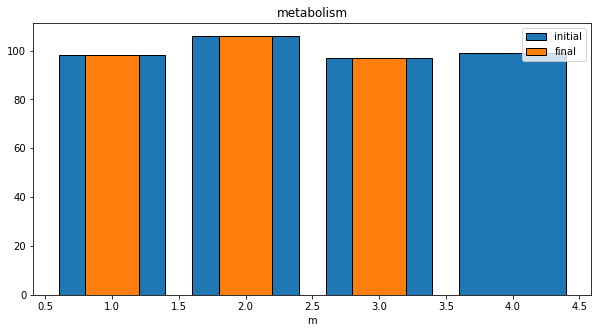

In [ ]:
# Metabolism: initial and final distribution.
m_bins = possible_m
m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('m')
plt.title('metabolism')
plt.show()





#### Vision

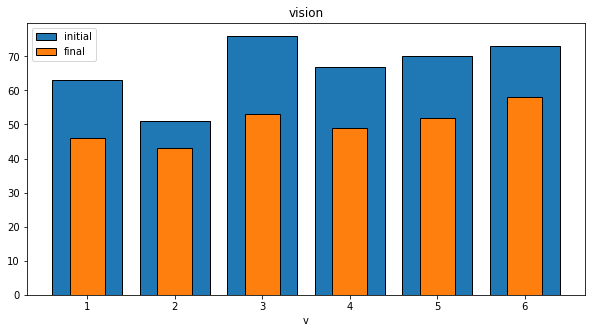

In [ ]:
# Vision: initial and final distribution.
v_bins = possible_v
v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('v')
plt.title('vision')
plt.show()


#### Sugar

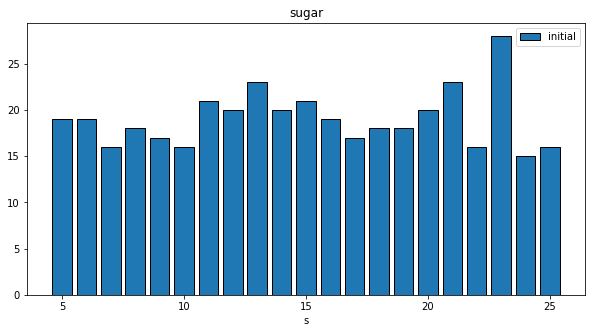

In [ ]:
# Sugar: initial and final distribution.
s_bins_i = possible_s
s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

plt.figure(figsize=(10, 5))
plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
plt.legend()
plt.xlabel('s')
plt.title('sugar')
plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
def Lorenz_curve(s):
    """
    Function to generate the Lorenz curve from a sequence of data.
    
    Parameters
    ==========
    s : Sugar of each agent.
    """
    
    N = np.size(s)
    
    population_fraction = np.arange(N) / N
    
    s_sorted = np.sort(s)
    
    cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
    return cumulative_s_fraction, population_fraction

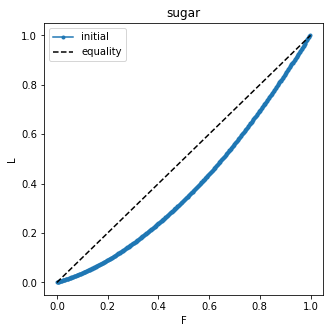

In [ ]:
L0, F0 = Lorenz_curve(S0)


plt.figure(figsize=(5, 5))
plt.plot(F0, L0, '.-', label='initial')
plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
plt.legend()
plt.xlabel('F')
plt.ylabel('L')
plt.title('sugar')
plt.show()


